## Домашнее задание Кошкиной Ксении

## Домашнее задание 3
### RNN архитектуры 


В этой домашке будем разбираться с RNN и учиться работать со статьями, я нашла для вас вот такую достаточно уже старую, но при этом несложно написанную, статью с хорошо описанными экспериментами, в современных реалиях, она конечно не state of the art, но она хорошо подойдет для наших целей. 
1) прочитайте статью https://arxiv.org/pdf/1511.08630.pdf
2) мы будем ставить эксперименты на других данных, поэтому, проанализируйте и сделайте препроцессинг на основании вашего анализа и того дизайна экспериментов, который описан в статье, для этого датасета https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv 

Задача: предсказать категорию новости (там есть дополнительная колонка, не обращаем внимание, что это датасет fakenews, в этом дз нас интересует тематика новости)
3) реализуйте на pytorch ту архитектуру модели, которую в итоге тестировали авторы (подробное описание есть в статье), таким образом, чтобы это был пайплайн для проведения экспериментов: можно было запускать модель с разными гиперпараметрами, разными способами регуляризации, описанными в статье (в том числе, чтобы можно было вставлять ее в разных местах), паддингом, векторизацией.  
4) поставьте эксперименты с разными параметрами и особенностями архитектуры (регуляризация, паддинг, векторизация, драпаут и тд, в статье подробно описан смысл этих операций и что конкретно делали, загуглите как это имплементировано в торче) так как описано в статье (там есть подробное описание в разделе 5.2 Experimental Settings )
5) оцените результаты экспериментов также, как это сделали в статье 
6) напишите выводы (это должно быть похоже на раздел Results and Model Analysis только не нужно сравнивать с другими моделями, как это делают авторы статьи, сравнивайте только результаты своих экспериментов, потому что там цифры на других датасетах. Да писать так много тоже не нужно, но у вас и должно получиться меньше потому что не будет сравнения)


Если вы хотите дополнительный балл:
1) реализуйте классы для RNN, LSTM и GRU ячейки 
2) реализуйте класс RNN слоя

Если вы хотите еще один дополнительный балл, то используйте в экспериментах не RNN слой из торча, а свой самочинный слой, с разными типами ячеек (то есть поставьте дополнительные эксперименты не только с LSTM слоем, но и с обычным RNN и GRU слоем) 

In [9]:
! pip install torchmetrics

In [10]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
from collections import Counter
from torch.optim import RMSprop
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch.nn.functional as F
from torchmetrics.functional import f1, recall, accuracy
from torch.nn.utils.rnn import pad_sequence
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
DEVICE = device

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
data = pd.read_csv('/content/drive/MyDrive/Fake.csv')

In [15]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [16]:
def preprocessing(text):
  text = word_tokenize(text.lower())
  return text

In [17]:
data['preprocess_text'] = [preprocessing(x) for x in data['text'].tolist()]

In [18]:
data.head()

,title,text,subject,date,preprocess_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ..."


In [19]:
data['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

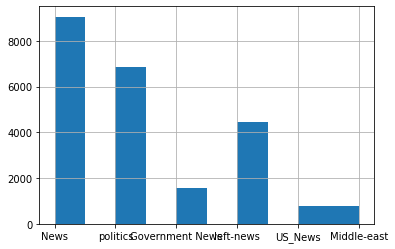

In [20]:
data['subject'].hist()

In [21]:
data['sub'] = data['subject'].astype('category').cat.codes

In [22]:
data.head()

,title,text,subject,date,preprocess_text,sub
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am...",2
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev...",2
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme...",2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc...",2
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ...",2


In [23]:
datas = data[['preprocess_text','sub']]

In [24]:
train_data, test_data = train_test_split(datas, test_size=0.2,shuffle=True, random_state=seed)

In [25]:
vocab = Counter()

for text in datas['preprocess_text']:
    vocab.update(text)
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 181384


In [26]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 3:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 3 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 3 раз: 48322


In [27]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'UNK':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [28]:
len(word2id)

48323

In [29]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [30]:
MAX_LEN = 0

for text in data.preprocess_text:
    MAX_LEN = max(len(text), MAX_LEN)
MAX_LEN

9938

Уменьшаем длину, потому максимальная длина слишком длинная


In [31]:
MAX_LEN = 200

In [32]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-29 20:46:10--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.230.16
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.230.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.6MB/s    in 1m 42s  

2021-12-29 20:47:52 (15.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [33]:
import gensim
w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [34]:
weights = np.zeros((len(word2id), 300))
for word, i in word2id.items(): 
    try:
        weights[i] = w2v[word]    
    except KeyError:
        weights[i] = np.random.normal(0,0.1,300)

In [35]:
class NewsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = datas['preprocess_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(datas['sub'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index] 
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        ids = F.pad(ids, (0, MAX_LEN - len(ids)))
        y = self.target[index]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = torch.vstack([F.pad(idx, pad=(0, self.max_len - idx.shape[0]), mode='constant', value=0) for idx in ids])
      y = torch.LongTensor(y)
      y = y.torch.LongTensor.T[0].to(self.device)
      return padded_ids, y

In [49]:
train_dataset = NewsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [50]:
val_dataset = NewsDataset(test_data, word2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [94]:
import numpy as np


class C_LSTM(nn.Module):


  def __init__(self, max_len, filter_sizes, vocab_size, 
                 embedding_dim, filter_num, drop, hidden, 
                 num_layers, weights, dropout_number):
    super().__init__()
    self.vocab_size = vocab_size 
    self.max_len = max_len
    self.filter_sizes = filter_sizes  
    self.filter_number = filter_num
    self.drop = drop
    self.hidden = hidden
    self.num_layers = num_layers
    self.dropout_number = dropout_number

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.from_pretrained(torch.tensor(weights)) 

    c_layers = []
    for size in filter_sizes:
      conv = nn.Conv1d(in_channels=embedding_dim,
                       out_channels=filter_num,
                       kernel_size=size)
      c_layers.append(conv)
    self.c_layers = nn.ModuleList(c_layers)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=self.dropout_number)
    self.softmax = nn.Softmax(dim=1)

    self.lstm = nn.LSTM(input_size=self.filter_number*self.num_layers,
                        hidden_size=self.hidden, 
                        num_layers=self.num_layers, 
                        batch_first=True)

    self.linear = nn.Linear(self.hidden, 6)

  def forward(self, word):
    embedded = self.embedding(word)
    if self.drop == 'first':
      embedded = self.dropout(embedded)
    embedded = embedded.transpose(1, 2)

    max_feature_len = self.max_len - max(self.filter_sizes) + 1  
    out = []
    for c in self.c_layers:
      feature = self.relu(self.c(embedded)).transpose(1,2)
      out.append(feature)
    
    if len(self.filter_sizes) > 1:
      input = torch.cat(out, -1)
    else:
      input = out[0]
            
    _, (state, _) = self.lstm(input)
    if self.drop == 'last':
      embedded = self.dropout(embedded)
    logits = self.softmax(self.linear(torch.squeeze(state, 0)))
    return logits 

In [67]:
def train(model, iterator, optimizer, criterion, metric, device):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        texts = texts.to(device)
        ys = ys.to(device)
        preds = model(texts.squeeze())  #прогоняем данные через модель
        loss = criterion(preds, ys.long()) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds, ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 100:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [68]:
def evaluate(model, iterator, criterion, metric, device):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            texts = texts.to(device)
            ys = ys.to(device)
            preds = model(texts.squeeze())  # делаем предсказания на тесте
            loss = criterion(preds, ys.long())   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds, ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 100:
              pass
              print(f'Val loss_ev: {loss.item()}, Val f1_ev: {batch_metric}')
                #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')

    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [69]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

In [70]:
values_drop_first = {}
all_values = []
all_filters = [[2], [3], [4], [2, 3], [3, 4], [2, 4], [2, 3, 4]]

### Drop=first, filter=2

In [96]:
#drop=first #filter=[2]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[2], vocab_size=len(word2id),
               embedding_dim=300, filter_num=1, drop='first', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [101]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 0
Training...


AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()